In [1]:
setwd("C:/Users/User/OneDrive/Documentos")
options(warn = -1)

In [2]:
pacotes <- c("tidyverse","tidyquant","tseries","BatchGetSymbols","forecast")
for(i in pacotes){
  suppressPackageStartupMessages(library(i, character.only = T))
}

In [3]:
acao <- "PETR4.SA"
n_acoes <- 80
brasil <- T
aleatorio <- T
data_inicio <- Sys.Date()-2*365
if(brasil){
  acoes1 <- GetIbovStocks(F)$tickers
  if(isTRUE(aleatorio)){
    s <- sample(1:length(acoes1),length(acoes1))
    acoes1 <- acoes1[s]
  }
  acoes <- acoes1[1:n_acoes]
  acoes <- paste0(acoes,".SA")
}else{
  acoes1 <- GetSP500Stocks(F)$Tickers
  if(aleatorio){
    s <- sample(1:length(acoes1),length(acoes1))
    acoes1 <- acoes1[s]
  }
  acoes <- acoes1[1:n_acoes]
}
acoes <- acoes[which(acoes != acao)]
p_val <- numeric(length(acoes))

In [5]:
suppressMessages(for(i in 1:length(acoes)){
  precos <- tq_get(c(acao,acoes[i]), from = data_inicio) %>%
    select(date, symbol, adjusted) %>%
    group_by(symbol) %>%
    summarise(date,adjusted = abs(adjusted)) %>%
    spread(key = symbol, value = adjusted) %>%
    na.omit
  precos_acao <- as.matrix(precos[acao]) %>% as.numeric
  p_val[i] <- NA
  try({preco_a <- as.matrix(precos[acoes[i]]) %>% as.numeric
  reg <- lm(preco_a ~ precos_acao)
  stationary <- adf.test(reg$residuals)
  p_val[i] <- stationary$p.value},silent = T)
})

In [10]:
names(p_val) <- acoes
cointegrado <- names(p_val[which(p_val <= 0.05)])
indexa <- 1

In [12]:
precos <- tq_get(c(acao,cointegrado[indexa]), from = data_inicio) %>%
  select(date, symbol, adjusted) %>%
  group_by(symbol) %>%
  summarise(date,adjusted = abs(adjusted)) %>%
  spread(key = symbol, value = adjusted) %>%
  na.omit
datas <- precos$date

`summarise()` has grouped output by 'symbol'. You can override using the `.groups` argument.



In [13]:
print(cointegrado)

[1] "PETR3.SA" "BBDC4.SA" "MRFG3.SA" "ABEV3.SA" "BBDC3.SA" "PCAR3.SA" "UGPA3.SA"


In [14]:
dife <- apply(precos[,-1],2,function(x)c(0,diff(x)/x[2:length(x)-1]))
preco1 <- as.matrix(precos[cointegrado[indexa]]) %>% as.numeric
preco2 <- as.matrix(precos[acao]) %>% as.numeric
regr <- lm(preco1 ~ preco2)
base1 <- quantile(regr$residuals,0.85)
base2 <- quantile(regr$residuals,0.15)
res <- numeric(nrow(precos))
dados <- character(nrow(precos))
data_i <- xts::first(datas)
peso <- 1

In [15]:
for(i in 1:length(res)){
  if(regr$residuals[i] >= base1){
    res[i] <- peso*dife[i,cointegrado[indexa]]+(1-peso)*dife[i,acao]
    dados[i] <- paste("Compra de",cointegrado[indexa],"e venda de",acao)
  }else if(regr$residuals[i] <= base2){
    res[i] <- peso*dife[i,acao]+(1-peso)*dife[i,cointegrado[indexa]]
    dados[i] <- paste("Compra de",acao,"e venda de",cointegrado[indexa])
  }else{
    res[i] <- 0.5*dife[i,cointegrado[indexa]]+0.5*dife[i,acao]
    dados[i] <- "Neutro"
  }
}

In [16]:
resultado <- cumprod(res+1)
resultado_acoes <- apply(dife+1,2,cumprod)

In [17]:
resultado_tot <- data.frame(date = datas, Sinal = dados,
                            Operações = resultado,
                            resultado_acoes)
resultado_tot_g <- resultado_tot %>%
  gather(key = "key", value = "Resultado", -c(date,Sinal))

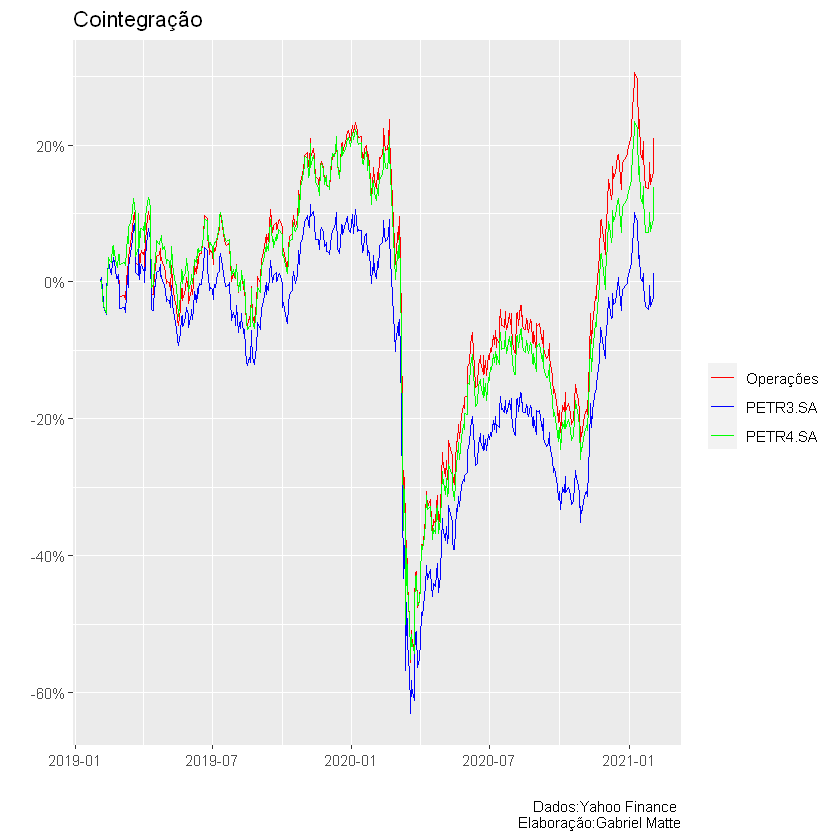

In [18]:
ggplot(resultado_tot_g, aes(x = date, y = Resultado-1, col = key))+
  geom_line()+
  scale_y_continuous(labels = scales::percent)+
  labs(x = "", y = "", title = "Cointegração",
       caption = "Dados:Yahoo Finance \n Elaboração:Gabriel Matte")+
  scale_color_manual("", values = c("red","blue","green"))

In [19]:
tail(resultado_tot,4)

,date,Sinal,Operações,PETR3.SA,PETR4.SA
,<date>,<chr>,<dbl>,<dbl>,<dbl>
490,2021-01-28,Neutro,1.174399,0.9949397,1.101967
491,2021-01-29,Neutro,1.141730,0.9646740,1.074180
492,2021-02-01,Compra de PETR4.SA e venda de PETR3.SA,1.161561,0.9778936,1.092837
493,2021-02-02,Compra de PETR4.SA e venda de PETR3.SA,1.209238,1.0116380,1.137694


In [20]:
coeficientes <- coef(regr)
names(coeficientes) <- c("(Intercept)",acao)
print(coeficientes)

(Intercept)    PETR4.SA 
  -1.774250    1.118311 


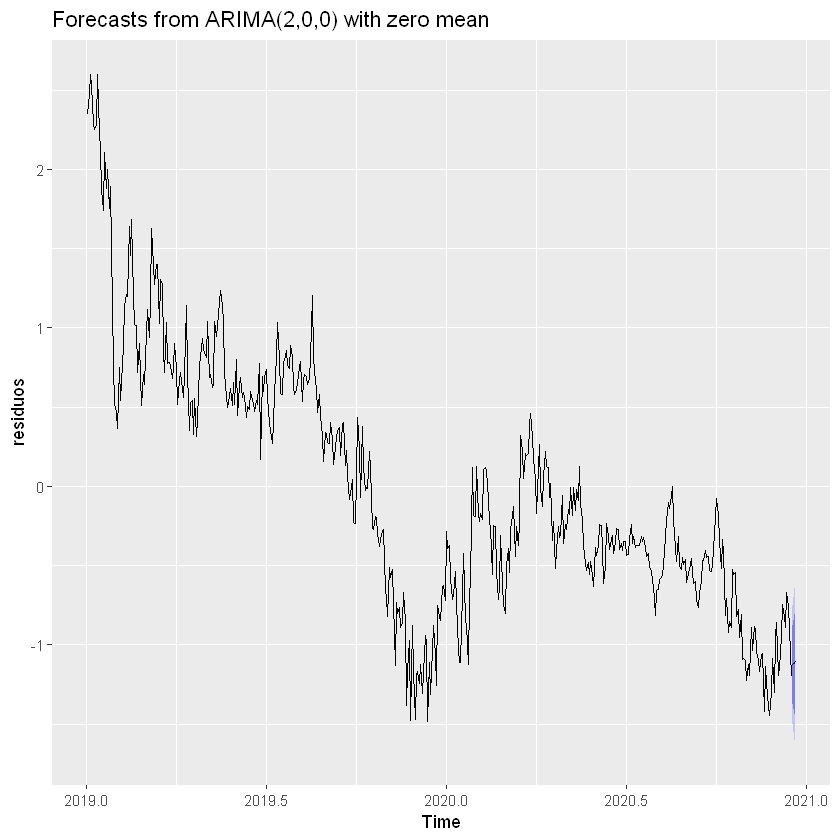

In [21]:
residuos <- ts(regr$residuals, 
               start = c(year(data_i), month(data_i), day(data_i)),
               frequency = 252)
ar <- auto.arima(residuos, stationary = T)
n_f <- 3
fore <- forecast(ar,h = n_f)
autoplot(fore)

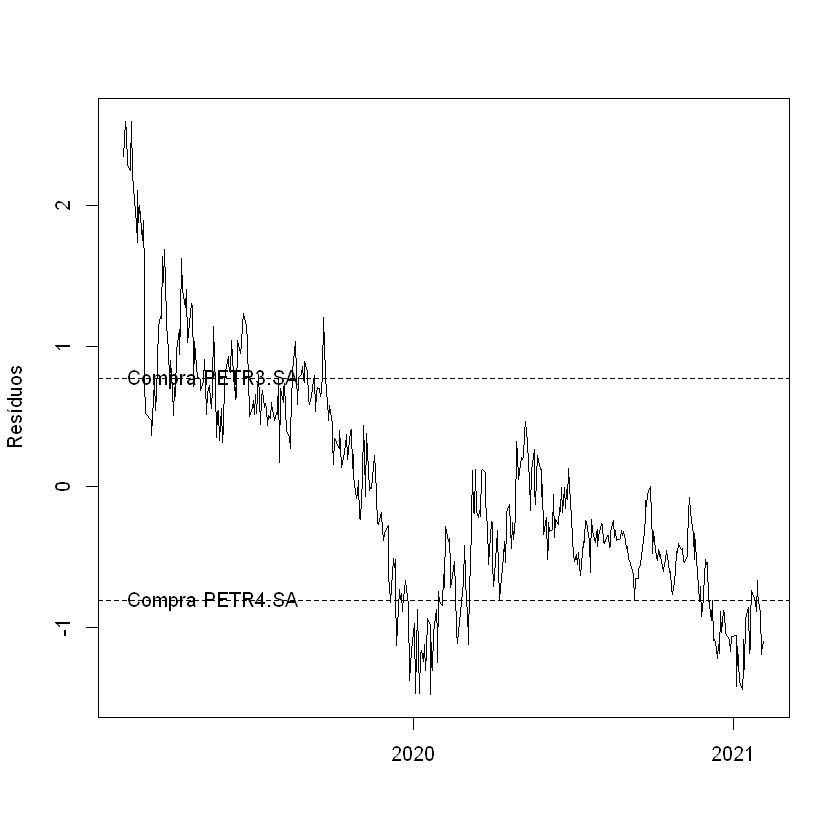

In [22]:
plot(c(datas,xts::last(datas)+1:n_f),c(regr$residuals,fore$mean), type = "l", xlab = "", ylab = "Resíduos")
abline(h = c(base1,base2), lty = 2)
text(datas[70], y = base2, labels = paste("Compra",acao))
text(datas[70], y = base1, labels = paste("Compra",cointegrado[indexa]))

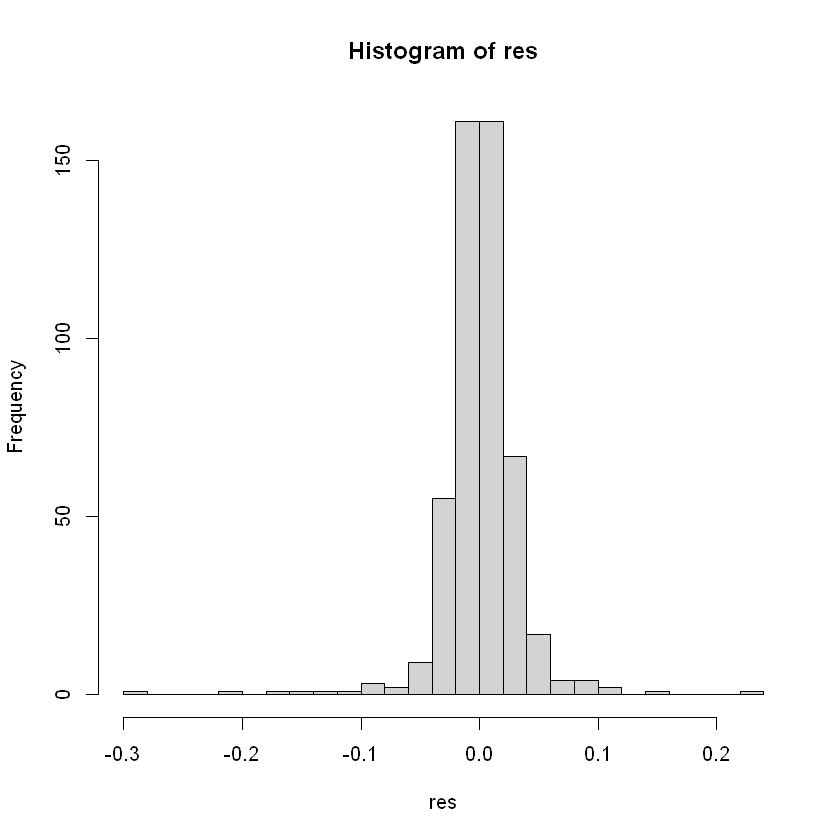

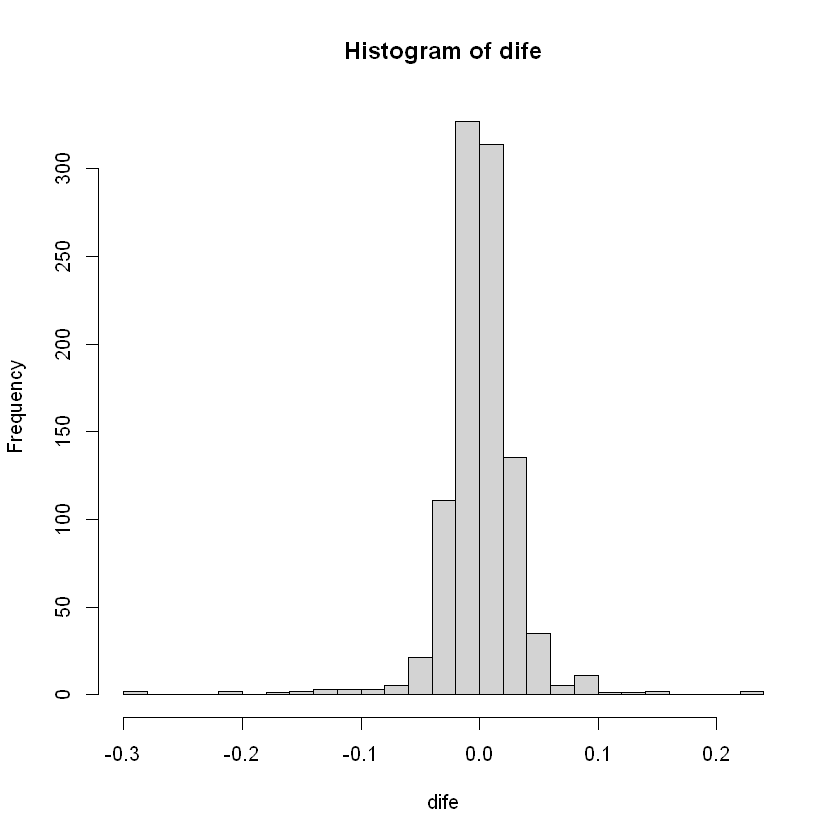

In [23]:
hist(res, breaks = 30)
hist(dife, breaks = 30)

In [24]:
mean(res)*252
sd(res)*sqrt(252)

[1] 0.2512704

[1] 0.5434008